# Notebook Content 
- Exploratory Data Analysis
  - Cleaning
  - Visualization 
- Natural Language Processing 
  - Text Cleaning 
  - Topic Modeling 
  - Scatter Text
  - Corex
- Classification
  - Building Classification Models
  - Making Prediction on Chosen Model
- Clustering 
  - DBSCAN
  - TSNE

# Importing Libraries

In [167]:
import nltk
import pandas as pd
import re
import numpy as np
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import pickle
from nltk.tokenize import TweetTokenizer
from nltk import SnowballStemmer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities, matutils
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import imblearn.over_sampling
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import cluster
import re
import string
import sqlite3 as sql
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostRegressor, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler
import scattertext as st
from corextopic import corextopic as ct
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import pickle 
from scipy.linalg import svd

# Methods & Classes Used

###### NLPPipe class manages all of the training, transforming, and modification of the text data

In [168]:
class NLPPipe:
    def __init__(
        self,
        vectorizer=CountVectorizer(),
        tokenizer=None,
        cleaning_function=None,
        model=None,
        lemma=None
    ):
        """
        A class for pipelining our data in NLP problems.
        The user provides a series of tools, and this class
        manages all of the training, transforming, and modification
        of the text data.
        ---
        Inputs:
        vectorizer: the model to use for vectorization of text data
        tokenizer: The tokenizer to use, if none defaults to split on spaces
        cleaning_function: how to clean the data,
            if None, defaults to the in built class
        """
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        self.lemma=lemma

    def splitter(self, text):
        """
        Default tokenizer that splits on spaces naively
        """
        return text.split(" ")

    def clean_text(self, text, tokenizer, lemma):
        """
        A naive function to lowercase all works can clean them quickly.
        This is the default behavior if no other cleaning function is specified
        """
        cleaned_text = []
        for post in text:
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if lemma:
                    low_word = lemma.lemmatize(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(" ".join(cleaned_words))
        return cleaned_text

    def fit(self, text):
        """
        Cleans the data and then fits the vectorizer with
        the user provided text
        """
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemma)
        self.vectorizer.fit(clean_text)
        self._is_fit = True

    def transform(self, text):
        """
        Cleans any provided data and then transforms the data into
        a vectorized format based on the fit function. Returns the
        vectorized form of the data.
        """
        if not self._is_fit:
            raise ValueError("Must fit the models before transforming!")
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemma)
        return self.vectorizer.transform(clean_text)


In [170]:
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [172]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [371]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' ,color='#fbb4ae', data = dfs[i][:n_feats])
        plt.show()

In [174]:
def get_recommendation(top, df_all, scores):
    recommendation = pd.DataFrame(columns = ['Lyric','Artist','Song_topic','topic'])
    count = 0
    for i in top:
        recommendation.at[count, 'Lyric'] = merged_data['Lyric'][i]
        recommendation.at[count, 'Artist'] = merged_data['Artist'][i]
        recommendation.at[count, 'Song_topic'] = merged_data['Song_topic'][i]
        recommendation.at[count, 'topic'] =  merged_data['topic'][i]
        count += 1
    return recommendation

In [175]:
def scatter(x, colors, num_topics):
    """
    Function to quickly visualize our TSNE data

    Args:
        x: Coordinates from TSNE
        colors: Variables to determine colors
        num_topics: Number of topics

    Returns:
        Plots TSNE in a nice scatter plot
    """
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_topics))
   
    # We create a scatter plot.
    f = plt.figure(figsize=(10, 10))
    ax = plt.subplot(aspect="equal")
    sc = ax.scatter(
        x[:, 0], x[:, 1], lw=0, s=30, c=palette[colors.astype(np.int)]
    )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis("off")
    ax.axis("tight")

    # We add the labels for each digit.
    txts = []
    for i in range(num_topics):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts


# Exploratory Data Analysis

- Reading Data 
- Cleaning Data 
- Visuallizaion Data
- Merging 2 Dataset

# Reading the 1st dataset

In [176]:
data = pd.read_csv('/Users/renadalbishri/Downloads/lyrics-data.csv')
#data = pd.read_csv('/Users/mohamad/Desktop/Project-NLP-Clustering/Song-Lyrics-NLP-Clustering/lyrics-data.csv')
data

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH
...,...,...,...,...,...
209517,/zeca-pagodinho/,Vou Botar Teu Nome Na Macumba,/zeca-pagodinho/vou-botar-teu-nome-na-macumba....,Eu vou botar teu nome na macumba. Vou procurar...,PORTUGUESE
209518,/zeca-pagodinho/,Vou Procurar Esquecer,/zeca-pagodinho/vou-procurar-esquecer.html,Vou procurar um novo amor na minha vida. Porqu...,PORTUGUESE
209519,/zeca-pagodinho/,Vou Ver Juliana,/zeca-pagodinho/vou-ver-juliana.html,Quando a mare vazá. Vou vê juliana. Vou vê jul...,PORTUGUESE
209520,/zeca-pagodinho/,Yaô Cadê A Samba / Outro Recado / Hino,/zeca-pagodinho/yao-cade-a-samba-outro-recado-...,"Ô Yaô. Yaô, cadê a samba?. Está mangando na cu...",PORTUGUESE


### Do limitations on Idiom.
Only english song will be included in the analysis

In [177]:
data=data[data['Idiom']=='ENGLISH']

### Checking for duplicates and drop it

In [178]:
data.duplicated().value_counts()

False    91622
True     23101
dtype: int64

In [179]:
data.drop_duplicates(inplace=True)

### Git rid of all non-english characters.

In [180]:
def nospecial(text):
    text = re.sub("[^a-zA-Z0-9]+", " ", text)
    return text
data['Lyric'] = data['Lyric'].apply(lambda x: nospecial(x))

### Checking for missing values(NULL values)

In [181]:
data.isna().sum()

ALink    0
SName    0
SLink    0
Lyric    0
Idiom    0
dtype: int64

### Adding new column
A new column is added to the dataset to calculates the number of characters per song

In [182]:
data['length'] = data['Lyric'].str.split().str.len()

## Filtering Our Data Down
We need to do:

- Exclude song Lyric with under 20 characters.
- Choosing a 20000 Song Lyrics as sample from Dataset

In [183]:
data=data[data['length']>=20]

In [184]:
data=data.head(20000)

In [185]:
data['song_length']= [len(x.split(" ")) for x in data.Lyric]

In [186]:
Lyric_df=data['Lyric'].to_frame()

In [187]:
Lyric_df.head()

,Lyric
0,I could feel at the time There was no way of k...
1,Take me now baby here as I am Hold me close an...
2,These are These are days you ll remember Never...
3,A lie to say O my mountain has coal veins and ...
4,Trudging slowly over wet sand Back to the benc...


# Text Cleaning 
- Removed digits from texts
- Removed all punctuations.
- Made all text lowercase.

In [210]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

Lyric_df['Lyric'] = Lyric_df.Lyric.map(alphanumeric).map(punc_lower)
data['Lyric']=data.Lyric.map(alphanumeric).map(punc_lower)
#Lyric_df.head()
data.head()

,ALink,SName,SLink,Lyric,Idiom,length,song_length,song_topic
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of k...,ENGLISH,154,155,5
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close an...,ENGLISH,246,246,5
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember never...,ENGLISH,181,181,5
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,a lie to say o my mountain has coal veins and ...,ENGLISH,273,274,0
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,trudging slowly over wet sand back to the benc...,ENGLISH,117,117,2


## Transform Lyric column to list 
to easily deal with it

In [189]:
data_list=Lyric_df.Lyric.tolist()

In [190]:
data_list[:2]

['i could feel at the time there was no way of knowing fallen leaves in the night who can say where they re blowing as free as the wind hopefully learning why the sea on the tide has no way of turning more than this you know there s nothing more than this tell me one thing more than this you know there s nothing it was fun for a while there was no way of knowing like a dream in the night who can say where we re going no care in the world maybe i m learning why the sea on the tide has no way of turning more than this you know there s nothing more than this tell me one thing more than this you know there s nothing more than this you know there s nothing more than this tell me one thing more than this there s nothing ',
 'take me now baby here as i am hold me close and try and understand desire is hunger is the fire i breathe love is a banquet on which we feed come on now try and understand the way i feel under your command take my hand as the sun descends they can t hurt you now can t hu

# Natural Language Processing 
Preprocessing :
- Tokenization : Turn text into a meaningful format for analysis
- Vectorization
- Remove Stop words 

In [191]:
stopwords = nltk.corpus.stopwords.words('english')
add_these = ['oh','ve','ll','ooh','aaaahhhh','aaah','aaahhhh','aa','aaaaaaaaaaaaaaaaaaaa','aaaaaaaaaaaaaaaaaaaaaaa','aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
             'aaaaaaaaaaaaaaaaaaaaahaha','aaaaaaaaaahhh','aaaaaaaaaayyy','wa','aaaaaaa','aaaaaaaaah','aahhha','cuz','youre','youve','youâ','youll',
             'aaaaaaaah','aaaaaaaahh','aaaaaaahh','nigga','niggaz','daddy','mama','booty','aaow','aaronson','huh','take' , 'honey' , 'night', 'right', 'back', 'need', ' little' ,'long', 'sad', 'girl' , 'tonight',
             'être','aah','na','la','ca','wo','ah','cos','ba','ohh','yo','yeah','oo','woad','well','doo','da','mm','mmm','uh','hey','go','know','like','see','get','got','one','way','could','aaaaaaaaaaaah','aaaaaah',
             'make','thing','whoa','let','would','woo','love','yes','gonna','jesus','cause','yea','gimme','ha','bitch',
             'caus','come','want','though','say','tell','bout','aaaaaaaaaaaaaaaaaaaaaaaaa','aaaaah','aaaaahh','aaaagh','aaaah','aaaahh','aaaahhh','aaaahhhhhh','aaaahhhiyyyaaaa','aaah','ass'
            ,'aaahh','aaahhh','aaahhhhh','aaahhn','aaame','aaarrgg','aaarrgghh','aace','aahh','aahhh','oooo','ooo','nah','cha','thy','hi','ahhh'
            ,'aahhhh','aahow','aahs','aaliyah','aall','aand','aaoh','aaooohh','aar','aaron','zop','zorro','zp','zu','zulu','zurich','zy','zyyyy','zzy','zzzz'
            ,'aart','aaw','ab','woah','ho','aback','abacycle','abafa','abaixo','abalon','good','wanna','ya','gotta','please','never','ever','fuck','shit','sex','lyrics','babe','damn','fucking']
stopwords.extend(add_these)

## Vectorizations
- CountVectorizer
- TfidfVectorizer

In [192]:
cv = CountVectorizer(stop_words=stopwords,token_pattern="\\b[a-z][a-z]+\\b")
tfidf = TfidfVectorizer(stop_words=stopwords,max_df=0.80,min_df=10,token_pattern="\\b[a-z][a-z]+\\b")

## Create object instance from NLPPipe class that clean the text

In [193]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words=stopwords,max_df=0.80,min_df=10), cleaning_function=None, 
                       tokenizer=TweetTokenizer().tokenize,
                        lemma=WordNetLemmatizer())
nlp.fit(data_list)
cleaned_data=nlp.transform(data_list).toarray()# cleaned data was made by using the nlp object instance of a class

/Users/renadalbishri/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['little'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [194]:
cleaned_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Document-term-matrix for Data List using TfidfVectorizer 

In [195]:
cleaned_data_tfidf=tfidf.fit_transform(data_list).toarray()# cleaned data was made by using tfidf vectorizer
vectorized_df = pd.DataFrame(cleaned_data_tfidf,columns=tfidf.get_feature_names())
vectorized_df.head()

,abandon,abandoned,abide,ability,ablaze,able,aboard,absence,absent,absolute,...,york,young,younger,youth,zander,zero,zip,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Topic Modeling with Matrix Factorization
Using 3 models:
- NMF 
- LSA
- LDA 
<br>
And then choose the model which give us the meaningful topics

## Non-Negative Matrix Factorization (NMF)

In [196]:
nmf_model = NMF(6,random_state=8)
doc_topic = nmf_model.fit_transform(cleaned_data)
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)
#0 : reality , 1: Hertbreak , 2: Coming of age/Growing up, 3:  Friendship , 4: Home  ,5: Desire

/Users/renadalbishri/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
life, heart, world, eye, dream, light, live, fall, end, die

Topic  1
baby, cry, hold, gone, shake, heart, lord, lovin, maybe, kiss

Topic  2
man, little, rock, said, home, boy, woman, roll, old, around

Topic  3
time, mind, last, mine, friend, find, wait, every, gone, life

Topic  4
away, day, walk, far, run, stay, fade, gone, today, turn

Topic  5
feel, give, think, believe, something, nothing, always, everything, really, much


#### The NMF model  shows us the 6 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (Topic 1) seems to be about Reality
- Component 2 (Topic 2) seems to be about Hertbreak
- Component 3 (Topic 3) seems to be about Coming of age/Growing up
- Component 4 (Topic 4) seems to be about Friendship
- Component 5 (Topic 5) seems to be about Home
- Component 6 (Topic 6) seems to be about Desire

In [29]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4",'component_5','component_6'],
             columns =nlp.vectorizer.get_feature_names())
topic_word

,abandon,abandoned,abc,abide,ability,ablaze,able,aboard,absence,absent,...,york,young,younger,youth,zander,zero,zip,zombie,zone,zoo
component_1,0.008,0.016,0.000,0.008,0.002,0.006,0.023,0.003,0.007,0.002,...,0.000,0.129,0.006,0.032,0.000,0.011,0.001,0.001,0.008,0.001
component_2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,...,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000
component_3,0.002,0.001,0.005,0.002,0.003,0.000,0.007,0.007,0.000,0.001,...,0.058,0.120,0.012,0.008,0.000,0.010,0.003,0.005,0.017,0.008
component_4,0.000,0.000,0.000,0.000,0.001,0.000,0.007,0.002,0.000,0.002,...,0.001,0.010,0.001,0.005,0.005,0.000,0.000,0.001,0.000,0.000
component_5,0.000,0.004,0.000,0.000,0.000,0.000,0.001,0.000,0.004,0.000,...,0.000,0.005,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.000
component_6,0.006,0.000,0.000,0.000,0.000,0.000,0.007,0.000,0.007,0.001,...,0.000,0.000,0.013,0.000,0.004,0.010,0.000,0.000,0.009,0.000


### Topic per document

In [30]:
TPD = pd.DataFrame(doc_topic.round(5),
             index = data_list,
             columns = ["component_1","component_2","component_3","component_4",'component_5','component_6'])
TPD.head(3)

,component_1,component_2,component_3,component_4,component_5,component_6
i could feel at the time there was no way of knowing fallen leaves in the night who can say where they re blowing as free as the wind hopefully learning why the sea on the tide has no way of turning more than this you know there s nothing more than this tell me one thing more than this you know there s nothing it was fun for a while there was no way of knowing like a dream in the night who can say where we re going no care in the world maybe i m learning why the sea on the tide has no way of turning more than this you know there s nothing more than this tell me one thing more than this you know there s nothing more than this you know there s nothing more than this tell me one thing more than this there s nothing,0.01319,0.00000,0.00000,0.01105,0.00000,0.05019
take me now baby here as i am hold me close and try and understand desire is hunger is the fire i breathe love is a banquet on which we feed come on now try and understand the way i feel under your command take my hand as the sun descends they can t hurt you now can t hurt you now can t hurt you now because the night belongs to lovers because the night belongs to us because the night belongs to lovers cause the night belongs to us have i a doubt baby when i m alone love is a ring a telephone love is an angel disguised as lust here in our bed til the morning comes come on now try and understand the way i feel under your command take my hand as the sun descends they can t hurt you now can t hurt you now can t hurt you now because the night belongs to lovers because the night belongs to us because the night belongs to lovers because the night belongs to us with love we sleep with doubt the vicious circle turns and burns without you oh i cannot live forgive the yearning burning i believe it s time to heal to feel so take me now take me now take me now because the night belongs to lovers because the night belongs to us because the night belongs to lovers because the night belongs to us,0.01228,0.01913,0.00000,0.00252,0.00000,0.02356
these are these are days you ll remember never before and never since i promise will the whole world be warm as this and as you feel it you ll know it s true that you you are blessed and lucky it s true that you are touched by something that will grow and bloom in you these are days you ll remember when may is rushing over you with desire to be part of the miracles you see in every hour you ll know it s true that you are blessed and lucky it s true that you are touched by something that will grow and bloom in you these are days these are the days you might fill with laughter until you break these days you might feel a shaft of light make its way across your face and when you do you ll know how it was meant to be see the signs and know their meaning you ll know how it was meant to be hear the signs and know they re speaking to you to you,0.02568,0.00106,0.00333,0.00309,0.01908,0.03080


### Topic per document number

In [31]:
TPDN = pd.DataFrame(doc_topic.round(5), 
             index = data_list,
             columns = range(6))
TPDN.head()

,0,1,2,3,4,5
i could feel at the time there was no way of knowing fallen leaves in the night who can say where they re blowing as free as the wind hopefully learning why the sea on the tide has no way of turning more than this you know there s nothing more than this tell me one thing more than this you know there s nothing it was fun for a while there was no way of knowing like a dream in the night who can say where we re going no care in the world maybe i m learning why the sea on the tide has no way of turning more than this you know there s nothing more than this tell me one thing more than this you know there s nothing more than this you know there s nothing more than this tell me one thing more than this there s nothing,0.01319,0.00000,0.00000,0.01105,0.00000,0.05019
take me now baby here as i am hold me close and try and understand desire is hunger is the fire i breathe love is a banquet on which we feed come on now try and understand the way i feel under your command take my hand as the sun descends they can t hurt you now can t hurt you now can t hurt you now because the night belongs to lovers because the night belongs to us because the night belongs to lovers cause the night belongs to us have i a doubt baby when i m alone love is a ring a telephone love is an angel disguised as lust here in our bed til the morning comes come on now try and understand the way i feel under your command take my hand as the sun descends they can t hurt you now can t hurt you now can t hurt you now because the night belongs to lovers because the night belongs to us because the night belongs to lovers because the night belongs to us with love we sleep with doubt the vicious circle turns and burns without you oh i cannot live forgive the yearning burning i believe it s time to heal to feel so take me now take me now take me now because the night belongs to lovers because the night belongs to us because the night belongs to lovers because the night belongs to us,0.01228,0.01913,0.00000,0.00252,0.00000,0.02356
these are these are days you ll remember never before and never since i promise will the whole world be warm as this and as you feel it you ll know it s true that you you are blessed and lucky it s true that you are touched by something that will grow and bloom in you these are days you ll remember when may is rushing over you with desire to be part of the miracles you see in every hour you ll know it s true that you are blessed and lucky it s true that you are touched by something that will grow and bloom in you these are days these are the days you might fill with laughter until you break these days you might feel a shaft of light make its way across your face and when you do you ll know how it was meant to be see the signs and know their meaning you ll know how it was meant to be hear the signs and know they re speaking to you to you,0.02568,0.00106,0.00333,0.00309,0.01908,0.03080
a lie to say o my mountain has coal veins and beds to dig men with axes and they all dig for me a lie to ssay o my river where mant fish do swim half of the catch is mine when you haul your nets in never will he believe that his greed is a blinding ray no devil or redeemer will cheat him he ll take his gold to where he s lying cold a lie to say o my mine gave a diamond as big as a fist but with every gem in his pocket the jewels he has missed a lie to say o my garden is growing taller by the day he only eats the best and tosses the rest away never will he be believe that his greed is a blinding ray no devil or redeemer can cheat him he ll take his gold to where he s lying cold six deep in the grave something is out of reach something he wanted something is out of reach he s being taunted something is out of reach that he can beg or steal nor can he buy his oldest pain and fear in life there ll not be time his oldest pain and fear in life there ll not be time a lie to say o my forest has trees that block the sun and when i cut them down i don t answer to an

In [32]:
cosine_similarity((doc_topic[0], doc_topic[20])).round()

array([[1., 0.],
       [0., 1.]])

## Latent Semantic Analysis (LSA)
In LSA model Each topic is made up of a linear combination of the word features

In [33]:
lsa = TruncatedSVD(6,random_state=0)
doc_topic_lsa = lsa.fit_transform(cleaned_data)
lsa.explained_variance_ratio_

array([0.00324848, 0.0061933 , 0.00364914, 0.00346126, 0.00332778,
       0.00308873])

In [34]:
display_topics(lsa, nlp.vectorizer.get_feature_names(), 10)
#0 : reality , 1: Hertbreak , 2: Coming of age/Growing up, 3:  Friendship , 4: Home  ,5: Desire


Topic  0
time, baby, away, feel, day, life, heart, world, think, eye

Topic  1
baby, little, rock, woman, said, man, shake, roll, lord, lovin

Topic  2
rock, man, little, roll, boy, said, woman, old, everybody, big

Topic  3
time, think, mind, feel, give, really, much, believe, mine, last

Topic  4
away, time, day, gone, run, far, walk, home, stay, christmas

Topic  5
away, feel, give, rock, something, think, chorus, run, walk, roll


#### The LSA model shows us the 6 resulting topics, and the terms that are associated with each topic.In this case:
- Component 1 (Topic 1) seems to be about Reality
- Component 2 (Topic 2) seems to be about Hertbreak
- Component 3 (Topic 3) seems to be about Coming of age/Growing up
- Component 4 (Topic 4) seems to be about Friendship
- Component 5 (Topic 5) seems to be about Home
- Component 6 (Topic 6) seems to be about Desire

In [35]:
topic_word_lsa = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3","component_4",'component_5','component_6'],
             columns =nlp.vectorizer.get_feature_names())
topic_word_lsa

,abandon,abandoned,abc,abide,ability,ablaze,able,aboard,absence,absent,...,york,young,younger,youth,zander,zero,zip,zombie,zone,zoo
component_1,0.002,0.002,0.000,0.001,0.001,0.001,0.005,0.001,0.002,0.001,...,0.007,0.029,0.004,0.005,0.001,0.003,0.000,0.001,0.004,0.001
component_2,-0.001,-0.002,0.000,-0.001,-0.000,-0.000,-0.002,-0.000,-0.000,-0.000,...,0.001,-0.007,-0.001,-0.004,0.002,-0.001,-0.000,-0.000,-0.001,0.000
component_3,-0.000,-0.001,0.002,0.001,0.001,0.000,0.000,0.002,-0.001,0.000,...,0.015,0.028,0.003,0.000,-0.000,0.002,0.001,0.002,0.005,0.003
component_4,-0.000,-0.002,0.000,-0.001,0.000,-0.001,0.001,-0.000,-0.001,0.001,...,-0.003,-0.021,0.000,-0.003,0.002,-0.002,-0.000,-0.000,-0.001,-0.000
component_5,-0.001,0.001,0.000,0.000,-0.000,0.000,-0.001,0.001,-0.001,0.000,...,0.003,0.015,-0.001,0.004,-0.001,-0.002,-0.000,-0.000,-0.002,-0.000
component_6,-0.000,-0.001,0.000,-0.001,-0.001,-0.001,-0.002,-0.001,0.001,0.000,...,0.002,-0.022,0.001,-0.003,0.001,0.001,0.000,0.000,0.002,0.000


## Latent Dirichlet Allocation (LDA)

In [36]:
tfidf.fit(data_list)
doc_word = tfidf.transform(data_list).transpose()

In [37]:
pd.DataFrame(doc_word.toarray(), tfidf.get_feature_names()).head(10)

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
abandon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abandoned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablaze,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
able,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aboard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absence,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072818,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absolute,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert to gensim
We need to convert our sparse scipy matrix to a gensim-friendly object called a Corpus:

 #### Convert sparse matrix of counts to a gensim corpus

In [38]:
corpus = matutils.Sparse2Corpus(doc_word)

#### Map matrix rows to words (tokens)
We need to save a mapping (dict) of row id to word (token) for later use by gensim:

In [39]:
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

In [40]:
len(id2word)

7647

#### Create LDA model

In [41]:
lda = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=5)

Here are the 10 most important words for each of the 6 topics we found:

In [42]:
lda.print_topics()

[(0,
  '0.031*"christmas" + 0.008*"merry" + 0.007*"runaway" + 0.005*"hail" + 0.005*"thou" + 0.005*"di" + 0.005*"havin" + 0.004*"treated" + 0.004*"eve" + 0.004*"spanish"'),
 (1,
  '0.007*"sha" + 0.007*"lee" + 0.007*"riff" + 0.006*"modern" + 0.006*"church" + 0.005*"gal" + 0.005*"roller" + 0.004*"ohhhh" + 0.004*"railroad" + 0.003*"pig"'),
 (2,
  '0.006*"baby" + 0.005*"time" + 0.004*"away" + 0.004*"feel" + 0.004*"life" + 0.004*"heart" + 0.003*"day" + 0.003*"world" + 0.003*"think" + 0.003*"man"'),
 (3,
  '0.007*"jerry" + 0.006*"remains" + 0.006*"shelter" + 0.006*"bop" + 0.005*"divine" + 0.005*"justice" + 0.004*"helpless" + 0.004*"tore" + 0.004*"eh" + 0.004*"funeral"'),
 (4,
  '0.006*"rider" + 0.006*"washed" + 0.005*"sunny" + 0.005*"island" + 0.005*"murder" + 0.005*"holiday" + 0.004*"block" + 0.004*"grip" + 0.004*"float" + 0.004*"sweeter"'),
 (5,
  '0.007*"universe" + 0.006*"tearing" + 0.006*"danny" + 0.005*"famous" + 0.005*"aint" + 0.005*"heartache" + 0.005*"ordinary" + 0.004*"journey" + 0.

#### After seeing all topics from all models, we see **NMF** model give us the best meaningful topics so we choose it

## Documents Distribution Over Topics Using TSNE

In [43]:
plotting_x = TSNE(random_state=0,perplexity=50,metric='cosine').fit_transform(TPDN)

/Users/renadalbishri/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [201]:
data['song_topic'] = TPDN.idxmax(axis=1).tolist()
data['song_topic'].value_counts()

2    6224
0    5263
5    3280
3    2211
4    1660
1    1362
Name: song_topic, dtype: int64

#### Put the coordinates into our dataframe

In [256]:
data['x'] = plotting_x[:,1]
data['y'] = plotting_x[:,0]

<ipython-input-175-966c1aadfabb>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x[:, 0], x[:, 1], lw=0, s=30, c=palette[colors.astype(np.int)]


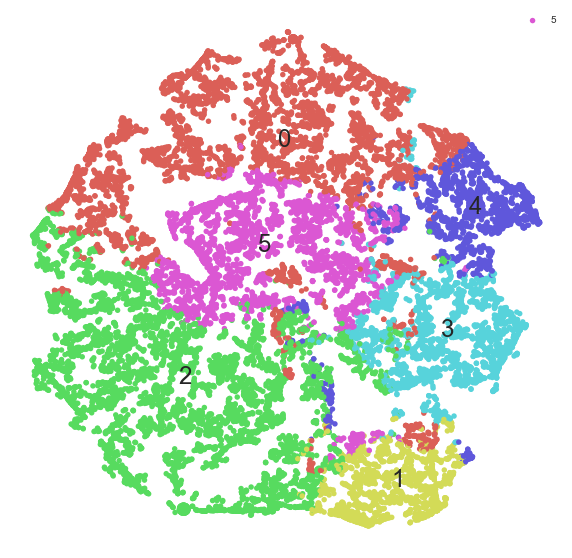

In [369]:
scatter(data[['x','y']].to_numpy(), data['song_topic'], 6);
plt.legend(data['song_topic'])

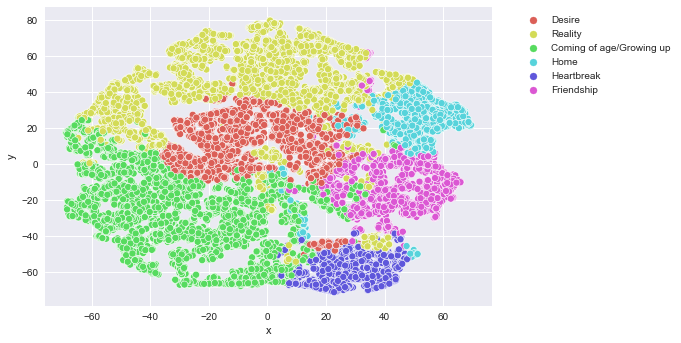

In [387]:
sns.scatterplot(x=data['x'],y=data['y'],hue=data['topic'],palette=sns.color_palette('hls',6),data=data)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('tsne.png',dpi=100, bbox_inches='tight')

In [362]:
data

,ALink,SName,SLink,Lyric,Idiom,length,song_length,song_topic,x,y
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of k...,ENGLISH,154,155,5,-1.713277,20.585844
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close an...,ENGLISH,246,246,5,21.206030,-43.489731
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember never...,ENGLISH,181,181,5,9.399012,25.967220
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,a lie to say o my mountain has coal veins and ...,ENGLISH,273,274,0,19.805105,19.628819
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,trudging slowly over wet sand back to the benc...,ENGLISH,117,117,2,-19.362976,-22.490675
...,...,...,...,...,...,...,...,...,...,...
29170,/johnny-rivers/,Ressurection,/johnny-rivers/ressurection.html,one day a man woke up to the rising sun listen...,ENGLISH,145,145,0,17.415907,65.517761
29171,/johnny-rivers/,Rhythm Of The Rain,/johnny-rivers/rhythm-of-the-rain.html,listen to the rhythm of the falling rain telli...,ENGLISH,208,209,4,55.556087,36.872051
29172,/johnny-rivers/,Rockin' Pneumonia And The Boogie Woogie Flu,/johnny-rivers/rockin-pneumonia-and-the-boogie...,i wanna jump but i m afraid i ll fall i wanna ...,ENGLISH,195,195,2,2.765550,-65.609390
29173,/johnny-rivers/,Roll Over Beethoven,/johnny-rivers/roll-over-beethoven.html,i m gonna write a little letter gonna mail it ...,ENGLISH,222,223,2,-28.334511,-67.099846


In [47]:
data.head()

,Lyric,song_topic,x,y
0,i could feel at the time there was no way of k...,5,-1.713277,20.585844
1,take me now baby here as i am hold me close an...,5,21.206030,-43.489731
2,these are these are days you ll remember never...,5,9.399012,25.967220
3,a lie to say o my mountain has coal veins and ...,0,19.805105,19.628819
4,trudging slowly over wet sand back to the benc...,2,-19.362976,-22.490675


In [202]:
data

,ALink,SName,SLink,Lyric,Idiom,length,song_length,song_topic
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time There was no way of k...,ENGLISH,154,155,5
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,Take me now baby here as I am Hold me close an...,ENGLISH,246,246,5
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are These are days you ll remember Never...,ENGLISH,181,181,5
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,A lie to say O my mountain has coal veins and ...,ENGLISH,273,274,0
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand Back to the benc...,ENGLISH,117,117,2
...,...,...,...,...,...,...,...,...
29170,/johnny-rivers/,Ressurection,/johnny-rivers/ressurection.html,One day a man woke up to the rising sun Listen...,ENGLISH,145,145,0
29171,/johnny-rivers/,Rhythm Of The Rain,/johnny-rivers/rhythm-of-the-rain.html,Listen to the rhythm of the falling rain Telli...,ENGLISH,208,209,4
29172,/johnny-rivers/,Rockin' Pneumonia And The Boogie Woogie Flu,/johnny-rivers/rockin-pneumonia-and-the-boogie...,I wanna jump but I m afraid I ll fall I wanna ...,ENGLISH,195,195,2
29173,/johnny-rivers/,Roll Over Beethoven,/johnny-rivers/roll-over-beethoven.html,I m gonna write a little letter gonna mail it ...,ENGLISH,222,223,2


# Visualization using WordCloud

We will use WordCloud in order to visualize the most frequent words in the all documents

In [149]:
!wget https://microventures.com/wp-content/uploads/team-1697987_640.png 

--2021-11-19 22:17:45--  https://microventures.com/wp-content/uploads/team-1697987_640.png
Resolving microventures.com... 146.148.53.236
Connecting to microventures.com|146.148.53.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31568 (31K) [image/png]
Saving to: 'team-1697987_640.png'

team-1697987_640.pn 100%[===================>]  30.83K   171KB/s    in 0.2s    

2021-11-19 22:17:47 (171 KB/s) - 'team-1697987_640.png' saved [31568/31568]



In [150]:
!mv team-1697987_640.png wf.png

In [153]:
img = Image.open("wf.png").convert('RGBA')
x = np.array(img)
r, g, b, a = np.rollaxis(x, axis = -1)
r[a == 0] = 255
g[a == 0] = 255
b[a == 0] = 255
x = np.dstack([r, g, b, a])
img = Image.fromarray(x, 'RGBA')

In [154]:
thresh = 200
fn = lambda x : 255 if x <= thresh else 0
wf_mask = img.convert('L').point(fn, mode='1')
wf_mask = np.array(wf_mask)

In [155]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [156]:
transformed_wf_mask = np.ndarray((wf_mask.shape[0],wf_mask.shape[1]), np.int32)

for i in range(len(wf_mask)):
    transformed_wf_mask[i] = list(map(transform_format, wf_mask[i]))

In [157]:
string_data=str(data_list)

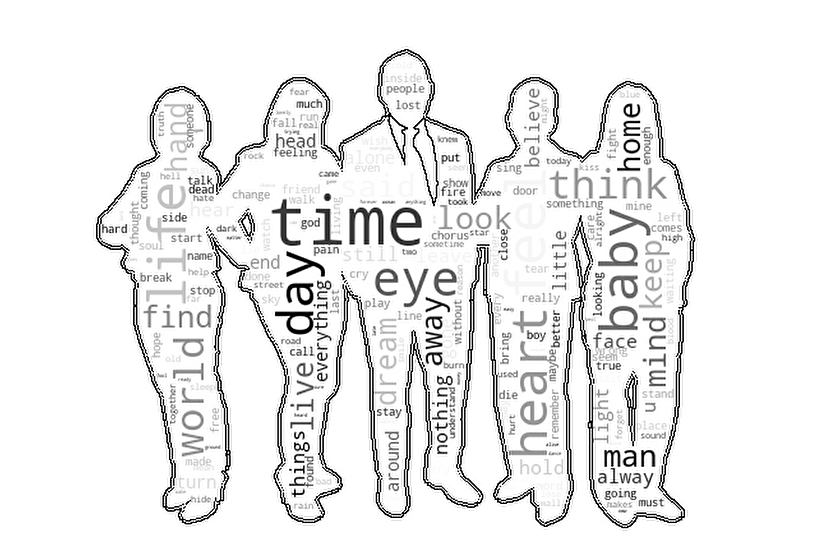

<Figure size 576x396 with 0 Axes>

In [282]:
wc = WordCloud(background_color="white", mask=transformed_wf_mask,
               stopwords=stopwords, contour_width=.1, contour_color='black',colormap='binary_r')

# Generate a wordcloud
wc.generate(string_data)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation="sinc")
plt.axis("off")
plt.show()
plt.savefig('WordCloud_all.png',dpi=100, bbox_inches='tight')

/Users/renadalbishri/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['little'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


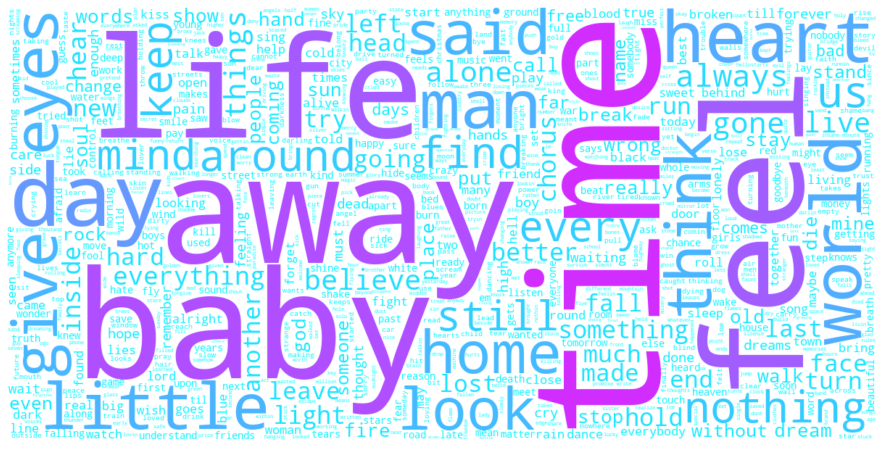

In [48]:
count = CountVectorizer(stop_words=stopwords)
count.fit(np.array(data_list))
freqs = np.array(count.transform(np.array(data_list)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count.get_feature_names(), freqs))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('cool', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');

## Word Cloud for each topic
We will use WordCloud in order to visualize the most frequent words in each topic

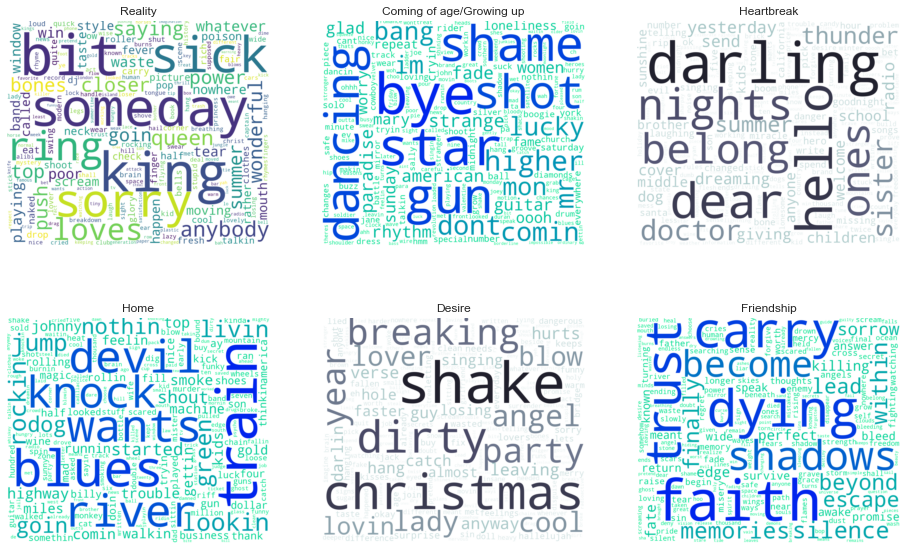

In [285]:
count = CountVectorizer(stop_words=stopwords, min_df=10, max_df=500)
X_vect = count.fit_transform(np.array(data_list))

# perform LDA and get the indices of top n_words_display words of each topic
n_components = 6
n_words_display = 200
lda_graph = LatentDirichletAllocation(n_components=n_components,random_state=8)
X_lda = lda_graph.fit_transform(X_vect)
indices = (-lda_graph.components_).argsort(axis=1)[:,:n_words_display]
vocab = np.array(count.get_feature_names())

# generate subplot axes
fig, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()

# plot word clouds
topics = ['Reality','Coming of age/Growing up','Heartbreak','Home','Desire','Friendship']
cmaps = ['bone_r', 'winter_r', 'bone_r', 'winter_r','bone_r','winter_r']
for i in range(n_components):
    if i == 0:
        color_func = None
    else:
        color_func = colormap_size_func(cmaps[i], 350)
    weights = lda_graph.components_[i][indices[i]]
    words = vocab[indices[i,:]]
    dictionary = dict(zip(words, weights))
    wordcloud = WordCloud(background_color='white', height=1200, min_font_size=5,
                      width=1400, color_func=color_func,
                      max_words=n_words_display, relative_scaling=0.5,
                      max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set(title=topics[i])

## Words Frequency 

In [50]:
min_count = 2
lyrics = Lyric_df['Lyric'].dropna().values.tolist()
lyrics_tokenized = [lyric.split() for lyric in lyrics]
model = Word2Vec(lyrics_tokenized, vector_size=50, min_count=min_count, window=5)

# create a list of tokens sorted by their frequency
count = CountVectorizer(stop_words=stopwords)
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)
mask = freqs >= min_count
indices = np.argsort(-freqs).squeeze().tolist()
freqs_filtered = freqs[indices]
words_sorted = np.array(count.get_feature_names())[indices]

# project the word embeddings of top n_words_display words down to 2 dimensions
n_words_display = 200
X = model.wv[words_sorted[:n_words_display]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

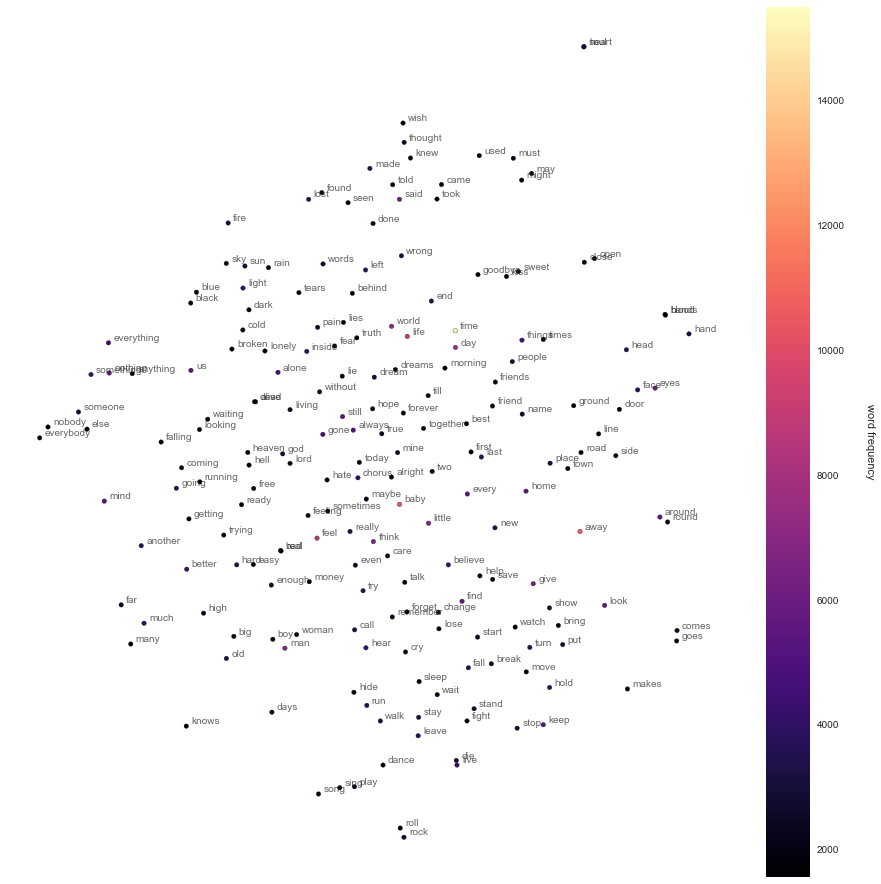

In [284]:
plt.figure(figsize=(16,16))
ax = plt.gca()
cb = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=20, c=freqs_filtered[:n_words_display],
                cmap='magma', edgecolor='black')
cb = plt.colorbar(cb)
cb.set_label('word frequency', rotation=270, labelpad=30)
ax.axis('off')

# annotate each point
for index, word in enumerate(words_sorted[:n_words_display]):
    xy = X_tsne[index]
    ax.annotate(word, xy=xy, xytext=(5,2), textcoords='offset points',
                 alpha=0.7)
plt.savefig('Word_frequency.png',dpi=100, bbox_inches='tight')

As we see, For example the most repeated words is **time** , **away** , **feel** and **life**

# Reading 2nd dataset

In [380]:
data2 = pd.read_csv('/Users/renadalbishri/Downloads/artists-data.csv')
data2

,Artist,Songs,Popularity,Link,Genre,Genres
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1,12 Stones,75,0.3,/12-stones/,Rock,Rock; Gospel/Religioso; Hard Rock; Grunge; Roc...
2,311,196,0.5,/311/,Rock,Rock; Surf Music; Reggae; Ska; Pop/Rock; Rock ...
3,4 Non Blondes,15,7.5,/4-non-blondes/,Rock,Rock; Pop/Rock; Rock Alternativo; Grunge; Blue...
4,A Cruz Está Vazia,13,0.0,/a-cruz-esta-vazia/,Rock,Rock
...,...,...,...,...,...,...
3237,Péricles,102,6.8,/pericles/,Samba,Romântico; Pagode; Samba; Sertanejo; Samba Enr...
3238,Rodriguinho,106,2.7,/rodriguinho/,Samba,Romântico; Pagode; Samba; Country; Hardcore; T...
3239,Sambô,71,0.8,/sambo/,Rock,Samba; Pagode; Rock; Pop/Rock; Soul Music; Cla...
3240,Thiaguinho,143,13.8,/thiaguinho/,Samba,Pagode; Romântico; Samba; Trilha Sonora; Black...


### Rename column

In [53]:
data2.rename(columns= {'Link' : 'ALink'}, inplace = True)

## Merge Datasets

In [216]:
merged_data=data2.merge(data, on='ALink')

### Explore Data After Combination

In [217]:
merged_data.head(3)

,Artist,Songs,Popularity,ALink,Genre,Genres,SName,SLink,Lyric,Idiom,length,song_length,song_topic
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of k...,ENGLISH,154,155,5
1,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close an...,ENGLISH,246,246,5
2,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember never...,ENGLISH,181,181,5


### Adding new column from Exist column in the dataset
Transform categorical topic to numerical topic

In [218]:
#0 : reality , 1: Hertbreak , 2: Coming of age/Growing up, 3:  Friendship , 4: Home  ,5: Desire
def topics(song_topics):
    if (song_topics == 0):
        return 'Reality'
    elif (song_topics == 1):
        return 'Heartbreak'
    elif (song_topics == 2):
        return 'Coming of age/Growing up'
    elif (song_topics == 3):
        return 'Friendship'
    elif (song_topics == 4):
        return 'Home'
    else:
        return 'Desire'

merged_data['topic'] = merged_data['song_topic'].apply(lambda x:topics(x))

In [363]:
#0 : reality , 1: Hertbreak , 2: Coming of age/Growing up, 3:  Friendship , 4: Home  ,5: Desire
def topics(song_topics):
    if (song_topics == 0):
        return 'Reality'
    elif (song_topics == 1):
        return 'Heartbreak'
    elif (song_topics == 2):
        return 'Coming of age/Growing up'
    elif (song_topics == 3):
        return 'Friendship'
    elif (song_topics == 4):
        return 'Home'
    else:
        return 'Desire'

data['topic'] = data['song_topic'].apply(lambda x:topics(x))

In [364]:
data

,ALink,SName,SLink,Lyric,Idiom,length,song_length,song_topic,x,y,topic
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of k...,ENGLISH,154,155,5,-1.713277,20.585844,Desire
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close an...,ENGLISH,246,246,5,21.206030,-43.489731,Desire
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember never...,ENGLISH,181,181,5,9.399012,25.967220,Desire
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,a lie to say o my mountain has coal veins and ...,ENGLISH,273,274,0,19.805105,19.628819,Reality
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,trudging slowly over wet sand back to the benc...,ENGLISH,117,117,2,-19.362976,-22.490675,Coming of age/Growing up
...,...,...,...,...,...,...,...,...,...,...,...
29170,/johnny-rivers/,Ressurection,/johnny-rivers/ressurection.html,one day a man woke up to the rising sun listen...,ENGLISH,145,145,0,17.415907,65.517761,Reality
29171,/johnny-rivers/,Rhythm Of The Rain,/johnny-rivers/rhythm-of-the-rain.html,listen to the rhythm of the falling rain telli...,ENGLISH,208,209,4,55.556087,36.872051,Home
29172,/johnny-rivers/,Rockin' Pneumonia And The Boogie Woogie Flu,/johnny-rivers/rockin-pneumonia-and-the-boogie...,i wanna jump but i m afraid i ll fall i wanna ...,ENGLISH,195,195,2,2.765550,-65.609390,Coming of age/Growing up
29173,/johnny-rivers/,Roll Over Beethoven,/johnny-rivers/roll-over-beethoven.html,i m gonna write a little letter gonna mail it ...,ENGLISH,222,223,2,-28.334511,-67.099846,Coming of age/Growing up


In [219]:
merged_data.head(5)

,Artist,Songs,Popularity,ALink,Genre,Genres,SName,SLink,Lyric,Idiom,length,song_length,song_topic,topic
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of k...,ENGLISH,154,155,5,Desire
1,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close an...,ENGLISH,246,246,5,Desire
2,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember never...,ENGLISH,181,181,5,Desire
3,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,A Campfire Song,/10000-maniacs/a-campfire-song.html,a lie to say o my mountain has coal veins and ...,ENGLISH,273,274,0,Reality
4,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,trudging slowly over wet sand back to the benc...,ENGLISH,117,117,2,Coming of age/Growing up


### Visualize Number of Songs Per Song Topic

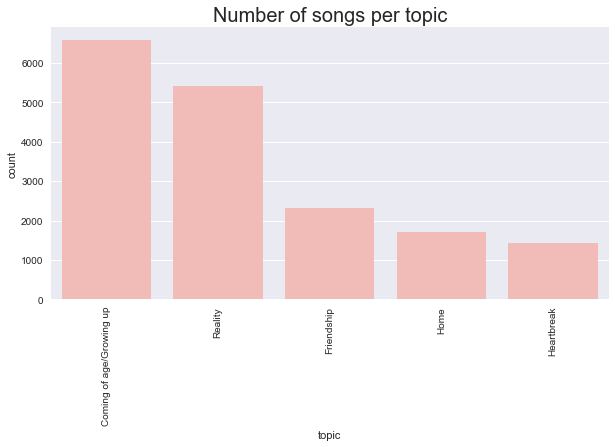

In [351]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
sns.countplot(x = "topic", data = merged_data,order=['Coming of age/Growing up','Reality','Friendship','Home','Heartbreak'],color='#fbb4ae')
plt.title('Number of songs per topic',fontsize=20)
plt.xticks(rotation=90)
plt.savefig('Topic.png',dpi=100, bbox_inches='tight')

As we see, the Coming of age/Growing up topic has the highest number of songs in the dataset.

# Classification Models

#### Take a copy from merged dataset to build classification models

In [73]:
classification_df=merged_data.copy()

#### Determine needed columns in the classification

In [74]:
classification_df=classification_df[['topic','song_topic','Lyric']]

In [75]:
classification_df.head()

,topic,song_topic,Lyric
0,Reality,0,i could feel at the time there was no way of ...
1,Desire,5,take me now baby here as i am hold me close...
2,Desire,5,these are these are days you ll remember nev...
3,Reality,0,a lie to say o my mountain has coal veins an...
4,Coming of age/Growing up,2,trudging slowly over wet sand back to the ben...


## Prepare Data for Modeling

#### Split the Features and Target

In [76]:
X=classification_df['Lyric']
y=classification_df['song_topic']

#### Split Train-Validation-Test
The data will be split into Train-Test and then into Train-Validate

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

#### Apply TfidfVectorizer on X_train, X_val , X_test

In [79]:
X_train_tfidf= tfidf.fit_transform(X_train)
X_val_tfidf  = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names()).head()

,abandon,abandoned,abc,abide,abiding,ability,ablaze,able,aboard,absence,...,young,younger,youth,zander,zero,zeros,zip,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.094534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Number of songs in each topics

In [78]:
y_train.value_counts()

2    6850
0    5527
4    2176
3    1565
5    1367
1    1288
Name: song_topic, dtype: int64

In [237]:
y_train

13268    1
19078    2
2753     2
7794     3
9626     0
        ..
11284    2
11964    2
5390     2
860      1
15795    1
Name: song_topic, Length: 18773, dtype: int64

As we see, our data is imbalance so we dealing with this problem using smote 

### Dealing with imbalance by smote

In [80]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=4001)
X_train_smote, y_train_smote = sm.fit_resample(X_train_tfidf, y_train)
pd.value_counts(y_train_smote)

0    6850
1    6850
2    6850
3    6850
4    6850
5    6850
Name: song_topic, dtype: int64

## Building Multiple Models 
And then choose the best one ( which give us the best score)

## Logistic Regression 

In [81]:
lr=LogisticRegression()
lr.fit(X_train_smote,y_train_smote)
print(lr.score(X_train_smote,y_train_smote))
print(lr.score(X_val_tfidf,y_val))

0.9945255474452555
0.9271332694151486


/Users/renadalbishri/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Decision Tree

In [82]:
DTC=DecisionTreeClassifier()
DTC.fit(X_train_smote,y_train_smote)
print(DTC.score(X_train_smote,y_train_smote))
print(DTC.score(X_val_tfidf,y_val))

1.0
0.789549376797699


## Random Forest

In [83]:
RFC=RandomForestClassifier()
RFC.fit(X_train_smote,y_train_smote)
print(RFC.score(X_train_smote,y_train_smote))
print(RFC.score(X_val_tfidf,y_val))

1.0
0.8667305848513902


## Gradient Boosting

In [84]:
GBC=GradientBoostingClassifier()
GBC.fit(X_train_smote,y_train_smote)
print(GBC.score(X_train_smote,y_train_smote))
print(GBC.score(X_val_tfidf,y_val))

0.9282968369829684
0.8130393096836049


## Multinomial

In [85]:
MNB=MultinomialNB()
MNB.fit(X_train_smote,y_train_smote)
print(MNB.score(X_train_smote,y_train_smote))
print(MNB.score(X_val_tfidf,y_val))

0.8658637469586374
0.664908916586769


 As we see, The Logistic Regression model give us the high score in validation set so we choose it. 

## Test Score on Chosen Model

In [236]:
print('LogisticRegression training score: ',lr.score(X_train_smote,y_train_smote))
print('LogisticRegression testing score: ',lr.score(X_test_tfidf,y_test))

LogisticRegression training score:  0.9945255474452555
LogisticRegression testing score:  0.9271332694151486


## Final Prediction for Chosen Model

In [86]:
from sklearn.preprocessing import LabelEncoder # to convert classes to number 
encoder = LabelEncoder()
y2 = encoder.fit_transform(classification_df['topic'])
y2

test_text = ["Days like this, I want to drive away Pack my bags and watch your shadow fade You chewed me up and spit me out Like I was poison in your mouth You took my light, you drained me down But that was then and this is now Now look at me"]
# convert to number
test_vector = tfidf.transform(test_text)
test_vector = test_vector.toarray()

## encodeing predict class
text_predict_class = encoder.inverse_transform(lr.predict(test_vector))
print(test_text[0], '.   The topic of this song is:  ---> : (',text_predict_class[0],')')

Days like this, I want to drive away Pack my bags and watch your shadow fade You chewed me up and spit me out Like I was poison in your mouth You took my light, you drained me down But that was then and this is now Now look at me .   The topic of this song is:  ---> : ( Heartbreak )


### Classification Report for Chosen Model

In [87]:
lr_y_pred=lr.predict(X_test_tfidf)
print("\n Classification report for classifier %s:\n%s\n" % (lr, metrics.classification_report(y_test, lr_y_pred)))


 Classification report for classifier LogisticRegression():
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       594
           1       0.97      0.93      0.95       133
           2       0.94      0.94      0.94       764
           3       0.94      0.91      0.93       187
           4       0.91      0.90      0.90       257
           5       0.90      0.91      0.90       151

    accuracy                           0.93      2086
   macro avg       0.93      0.92      0.92      2086
weighted avg       0.93      0.93      0.93      2086




As we see, The accuracy is very good which equal to **(0.93)**

## Calculate Error Rate

In [251]:
def ModelScores(actual, preds):
     print(" Error Rate: ", 1-(metrics.accuracy_score(actual, preds)))
ModelScores(y_test, lr_y_pred)  

 Error Rate:  0.07286673058485138


As shown, the Error Rate is very low which is equal to **(0.072866)**

In [88]:
y_test.value_counts()

2    764
0    594
4    257
3    187
5    151
1    133
Name: song_topic, dtype: int64

## Confusion Matrix for Chosen Model

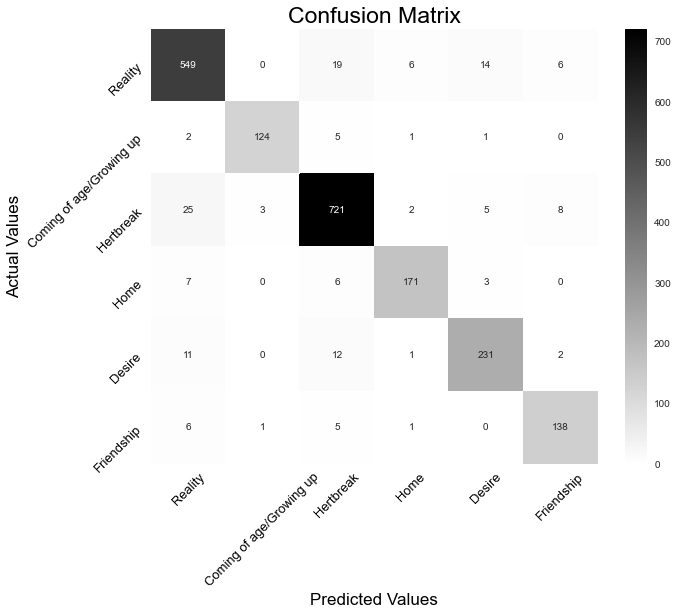

In [379]:
conf_mat = confusion_matrix(y_test, lr_y_pred)
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(conf_mat, cmap='binary',annot=True, fmt='.5g', ax=ax);
ax.set_xlabel('Predicted Values', fontsize=17, color='Black');
ax.set_ylabel('Actual Values',fontsize=17, color='Black'); 
ax.set_title('Confusion Matrix', color='Black', fontsize=23); 
plt.xticks(rotation=45)
plt.yticks(rotation=45)
ax.xaxis.set_ticklabels(['Reality','Coming of age/Growing up','Hertbreak','Home','Desire','Friendship'],fontsize=13, color='Black');
ax.yaxis.set_ticklabels(['Reality','Coming of age/Growing up','Hertbreak','Home','Desire','Friendship'],fontsize=13,color='Black');

Number of misclassified values: Reality : **45** ,Coming of age/Growing up: **9** , Heartbreak: **43** , Home: **16** ,Desire: **26** ,Friendship: **13**
<br> As we see, The most Topics Approximately correctly classify which has the less Number of misclassified values is **Coming of age/Growing up** and **Friendship**


### Saving the Chosen Model 

In [90]:
pickle_out = open("classifier.pkl", mode = "wb") 
pickle.dump(lr, pickle_out) 
pickle_out.close()

# Clustering

#### helper function that allows us to display data in 2 dimensions an highlights the clusters

In [303]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

## Take all of the data and plot it on 2 dimensions using PCA

In [93]:
pca = PCA(n_components=2)
pca.fit(cleaned_data)
pcafeatures = pca.transform(cleaned_data)

In [94]:
pca.explained_variance_ratio_

array([0.0061957, 0.0047757])

### Determining optimium number of clusters

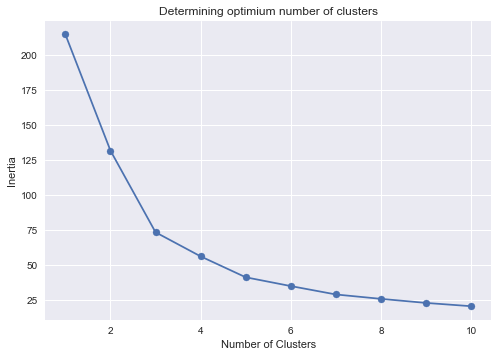

In [313]:
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(pcafeatures)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');
plt.title('Determining optimium number of clusters')
plt.savefig('elbow.png')

As we see, The best elbow in 5 so we choose the 5 clusters

## Visualize Clustering 

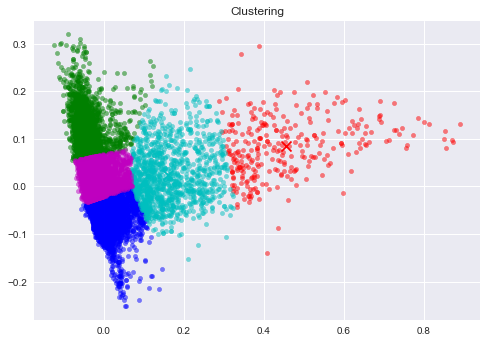

In [312]:
from sklearn.cluster import KMeans
num_clusters=5
km = KMeans(n_clusters=num_clusters)
km.fit(pcafeatures)
display_cluster(pcafeatures,km,num_clusters)
plt.title('Clustering')
plt.savefig('Clustering.png')

In [286]:
km.labels_.tolist()

[3,
 7,
 0,
 3,
 6,
 1,
 3,
 6,
 3,
 6,
 3,
 1,
 3,
 3,
 7,
 6,
 6,
 0,
 1,
 1,
 7,
 1,
 1,
 6,
 6,
 1,
 3,
 1,
 6,
 3,
 1,
 1,
 3,
 6,
 6,
 1,
 6,
 6,
 1,
 0,
 1,
 3,
 0,
 3,
 3,
 1,
 3,
 0,
 3,
 1,
 3,
 6,
 6,
 7,
 6,
 3,
 3,
 1,
 8,
 0,
 0,
 0,
 3,
 6,
 3,
 6,
 6,
 1,
 6,
 1,
 1,
 6,
 6,
 3,
 3,
 1,
 6,
 1,
 1,
 6,
 3,
 1,
 6,
 1,
 6,
 6,
 3,
 0,
 6,
 1,
 1,
 1,
 1,
 6,
 3,
 1,
 6,
 1,
 8,
 0,
 8,
 1,
 1,
 3,
 1,
 8,
 1,
 1,
 0,
 8,
 8,
 0,
 8,
 0,
 8,
 8,
 0,
 0,
 8,
 0,
 8,
 3,
 8,
 0,
 8,
 8,
 0,
 1,
 0,
 8,
 3,
 6,
 6,
 8,
 8,
 3,
 8,
 3,
 0,
 3,
 3,
 8,
 0,
 3,
 8,
 0,
 3,
 0,
 0,
 0,
 8,
 8,
 3,
 8,
 0,
 8,
 8,
 1,
 8,
 0,
 1,
 6,
 8,
 3,
 0,
 8,
 3,
 8,
 8,
 3,
 0,
 8,
 0,
 0,
 8,
 0,
 0,
 8,
 0,
 3,
 3,
 3,
 3,
 1,
 9,
 8,
 0,
 0,
 0,
 3,
 8,
 8,
 8,
 3,
 3,
 1,
 8,
 8,
 8,
 0,
 0,
 8,
 8,
 8,
 3,
 0,
 8,
 8,
 0,
 0,
 1,
 0,
 3,
 3,
 8,
 3,
 8,
 8,
 3,
 8,
 1,
 2,
 1,
 8,
 8,
 8,
 2,
 8,
 8,
 0,
 0,
 8,
 8,
 8,
 0,
 0,
 3,
 0,
 3,
 0,
 8,
 8,
 0,
 8,
 3,
 3,
 0,
 3,
 8,
 3,


### Clustering using DBSCAN 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

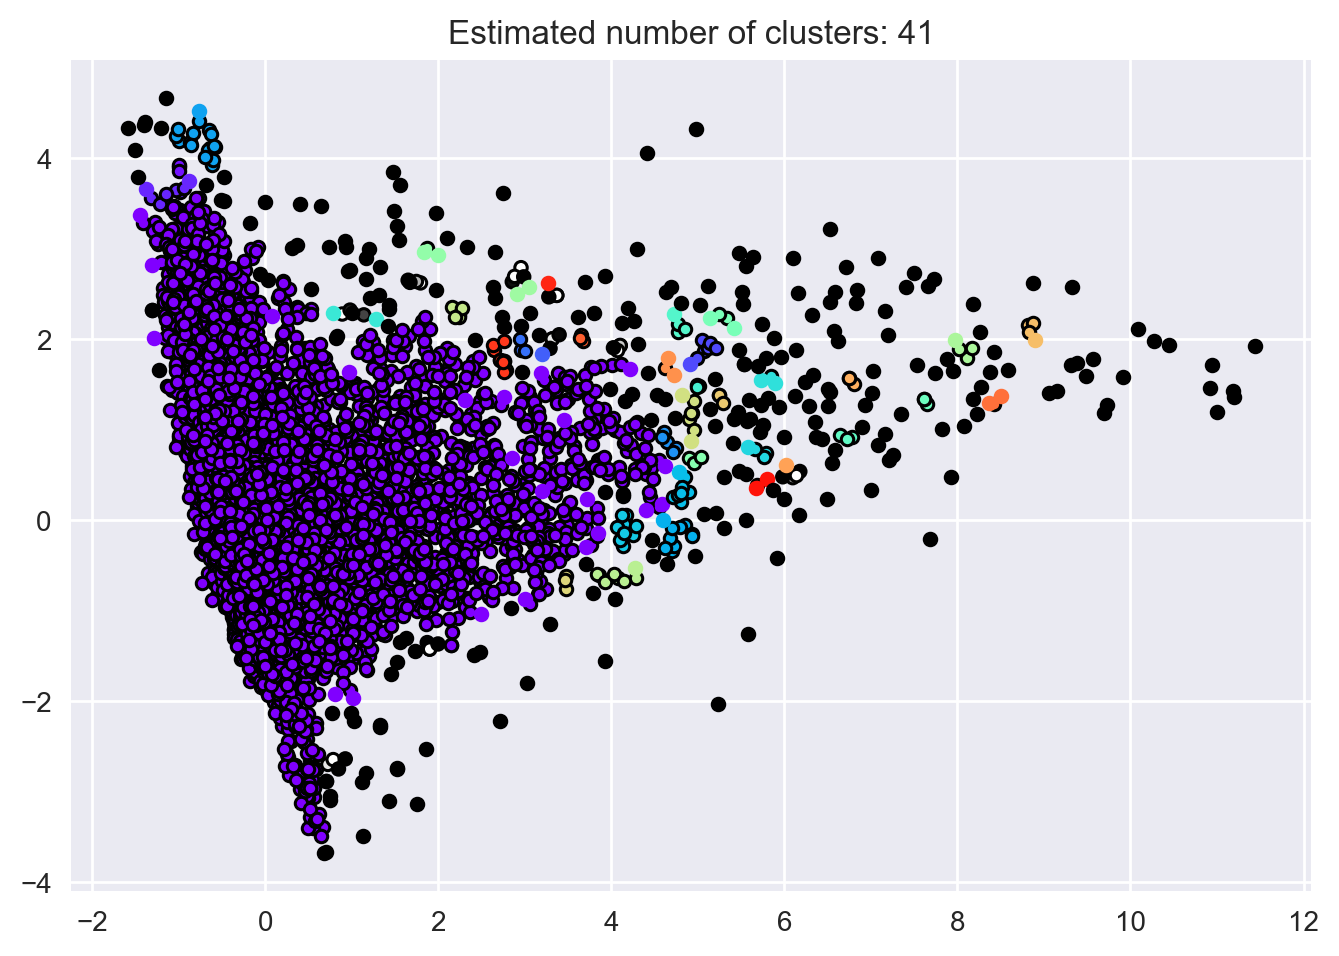

In [316]:
# Standardize our data for DBSCAN and fit DBSCAN
X = StandardScaler().fit_transform(pcafeatures)
db = DBSCAN(eps=0.15, min_samples=3).fit(X)

# Let's find the observations DBSCAN called "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);
plt.savefig('DBSCAN.png')

## Word Count for Each Cluster

In [102]:
tf_idf = pd.DataFrame(data = cleaned_data_tfidf, columns=tfidf.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

20000 rows


,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
nothing,0.521708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0282,0.0
learning,0.368931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
tide,0.338867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
knowing,0.308686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
turning,0.278902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0


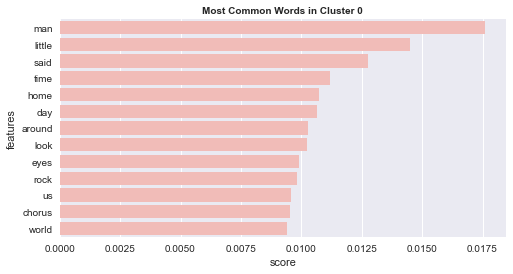

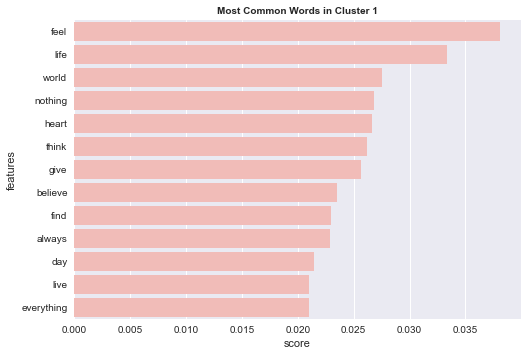

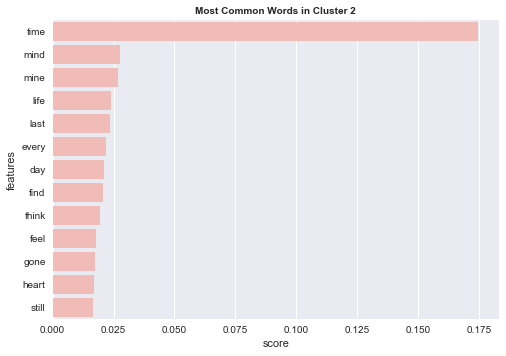

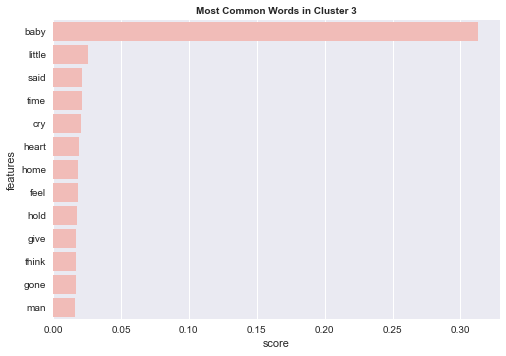

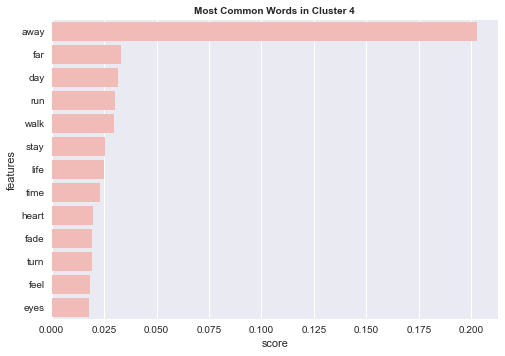

<Figure size 576x396 with 0 Axes>

In [372]:
best_result = 5
kmeans = KMeans(n_clusters=best_result)

final_df_array = final_df.to_numpy()
kmeans.fit(final_df)
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)
plt.savefig('common_words.png',dpi=100, bbox_inches='tight')

# Scatter Text

In [104]:
nlp = st.WhitespaceNLP.whitespace_nlp_with_sentences
merged_data['parsed'] = merged_data.Lyric.apply(nlp)

In [105]:
corpus = st.CorpusFromParsedDocuments(merged_data, category_col='topic', parsed_col='parsed').build().remove_terms(stopwords, ignore_absences=True)

We have **6** topics but here in **Scatter Text** we choose **2** topics which is **( Coming of age/Growing up ,Reality )**

In [106]:
html = st.produce_scattertext_explorer(corpus,
                                       category='Coming of age/Growing up',
                                       category_name='Coming of age/Growing up',
                                       not_category_name='Reality',
                                       use_full_doc=True,
                                       minimum_term_frequency=5,
                                       pmi_filter_thresold=10,
                                       term_ranker=st.OncePerDocFrequencyRanker,
                                       width_in_pixels=1000,
                                       sort_by_dist=False)
file_name = 'language_compare2.html'
open(file_name, 'wb').write(html.encode('utf-8'))

27366390

# CorEx

In [107]:
word_doc=tfidf.fit_transform(merged_data.Lyric)
bag_of_words=list(np.asarray(tfidf.get_feature_names()))

In [108]:
topic_model = ct.Corex(n_hidden=6, words=bag_of_words, seed=1)
topic_model.fit(word_doc, words=bag_of_words, docs=data_list)

### Print all topics from the CorEx topic model

In [109]:
topic_model.get_topics()
# ['die','live','life']
# ['cry','heart','break']
# ['man','young','grow','memories']
# ['friend','friendship']
# ['home','town','away']
# ['feel','believe','think']

[[('mike', 0.0035995827466875985, 1.0),
  ('mic', 0.003309515049093078, 1.0),
  ('rhymes', 0.003301023050880928, 1.0),
  ('adrock', 0.001964110382906011, 1.0),
  ('rhyme', 0.001803431839846957, 1.0),
  ('mc', 0.0016633980691831223, 1.0),
  ('def', 0.0013787287731608078, 1.0),
  ('funky', 0.0013413096936934167, 1.0),
  ('beastie', 0.001332567394909217, 1.0),
  ('mca', 0.001223577548035724, 1.0)],
 [('abandoned', 0.0, 1.0),
  ('quake', 0.0, 1.0),
  ('quietly', 0.0, 1.0),
  ('quits', 0.0, -1.0),
  ('quote', 0.0, -1.0),
  ('rag', 0.0, -1.0),
  ('rage', 0.0, 1.0),
  ('raging', 0.0, 1.0),
  ('raid', 0.0, -1.0),
  ('railroad', 0.0, -1.0)],
 [('abc', 0.0, -1.0),
  ('ramblin', 0.0, -1.0),
  ('raped', 0.0, 1.0),
  ('rarely', 0.0, 1.0),
  ('razors', 0.0, 1.0),
  ('read', 0.0, -1.0),
  ('realise', 0.0, 1.0),
  ('reality', 0.0, 1.0),
  ('realizing', 0.0, 1.0),
  ('reaper', 0.0, 1.0)],
 [('abandon', 0.0, -1.0),
  ('portion', 0.0, -1.0),
  ('portrait', 0.0, -1.0),
  ('pose', 0.0, -1.0),
  ('possessed

### Defining domain knowledge using **anchors**
- To see how the same word can be used in different topics
- Highlight smaller topics that may be otherwise hidden by larger topics

In [110]:
topic_model0 = ct.Corex(n_hidden=6, words=bag_of_words)
topic_model0.fit(word_doc, words=bag_of_words, docs=merged_data.Lyric,anchors=
[['life', 'die'],
['cry', 'heart'],
[ 'little',  'old'],
[ 'friend'],
['away','home'],
[ 'think', 'believe']],anchor_strength=8)

In [111]:
topics0=topic_model0.get_topics()
for n,topic in enumerate(topics0):
    topic_words,_,_=zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: die,life,live,imagine,alive,devastated,plenty,fixing,death,concern
1: cry,heart,ordinary,shadowy,droning,lonesome,quiver,bye,undone,wilder
2: little,mike,mic,rhymes,bit,adrock,mc,rhyme,rock,def
3: friend,blowin,telegraph,best,cryin,crossroads,answer,many,end,wrapped
4: home,away,coming,far,walk,fade,safety,alone,christmas,leave
5: believe,think,unbelievable,miracles,cemetery,jones,anything,lays,dont,repent


As we see, The resulting topic is the subtopic from our topic so we need to adding it in our dataframe

### Songs subtopic from CorEx topic model

In [112]:
merged_data['songs_subtopic'] =topic_model0.labels.tolist()
merged_data.head(3)

,Artist,Songs,Popularity,ALink,Genre,Genres,SName,SLink,Lyric,Idiom,length,song_topic,topic,parsed,songs_subtopic
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of ...,ENGLISH,154,0,Reality,"(i, could, feel, at, the, time, there, was, no...","[False, False, False, False, False, False]"
1,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close...,ENGLISH,246,5,Desire,"(take, me, now, baby, here, as, i, am, hold, m...","[False, False, False, False, False, False]"
2,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember nev...,ENGLISH,181,5,Desire,"(these, are, these, are, days, you, ll, rememb...","[False, False, False, False, False, False]"


As seen, The values of the new column is boolean which mean that True in the case of the Lyric belongs to these subtopic and False if the Lyric dosn't belongs to these subtopic

In [113]:
merged_data['songs_subtopic'] =topic_model0.labels
merged_data.head(3)

,Artist,Songs,Popularity,ALink,Genre,Genres,SName,SLink,Lyric,Idiom,length,song_topic,topic,parsed,songs_subtopic
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of ...,ENGLISH,154,0,Reality,"(i, could, feel, at, the, time, there, was, no...",False
1,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close...,ENGLISH,246,5,Desire,"(take, me, now, baby, here, as, i, am, hold, m...",False
2,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember nev...,ENGLISH,181,5,Desire,"(these, are, these, are, days, you, ll, rememb...",False


In [114]:
merged_data['songs_subtopic'].value_counts(ascending=True)

True       335
False    20524
Name: songs_subtopic, dtype: int64

#### Execlude the False Values and keep True values

In [115]:
df_subtopic=merged_data[merged_data['songs_subtopic']==True]

#### Label the sub topic

In [116]:
#0 : reality , 1: Hertbreak , 2: Coming of age/Growing up, 3:  Friendship , 4: Home  ,5: Desire
def topics(topics):
    if (topics == 'Reality'):
        return 'Reality of Death'
    elif (topics == 'Heartbreak'):
        return 'Losing Someone'
    elif (topics == 'Coming of age/Growing up'):
        return 'Local Band'
    elif (topics == 'Friendship'):
        return 'The End of Friendship'
    elif (topics == 'Home'):
        return 'Home Abandonment'
    elif (topics == 'Desire'):
        return 'Repentment'
    else:
        return None

df_subtopic['sub_topic'] = df_subtopic['topic'].apply(lambda x:topics(x))

In [117]:
df_subtopic.head(2)

,Artist,Songs,Popularity,ALink,Genre,Genres,SName,SLink,Lyric,Idiom,length,song_topic,topic,parsed,songs_subtopic,sub_topic
9,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Anthem For Doomed Youth,/10000-maniacs/anthem-for-doomed-youth.html,for whom do the bells toll when sentenced to ...,ENGLISH,190,2,Coming of age/Growing up,"(for, whom, do, the, bells, toll, when, senten...",True,Local Band
29,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Anthem For Doomed Youth,/10000-maniacs/anthem-for-doomed-youth.html,for whom do the bells toll when sentenced to ...,ENGLISH,190,2,Coming of age/Growing up,"(for, whom, do, the, bells, toll, when, senten...",True,Local Band


In [118]:
sample_artist=pd.DataFrame(df_subtopic.Artist)
sample_artist=sample_artist.head(30)

In [119]:
sample_topic=pd.DataFrame(df_subtopic.topic)
sample_topic=sample_topic.head(30)

In [120]:
sample_subtopic=pd.DataFrame(df_subtopic.sub_topic)
sample_subtopic=sample_subtopic.head(30)

In [121]:
megadf=pd.concat([sample_artist,sample_topic,sample_subtopic],axis=1)

In [122]:
megadf=megadf.reset_index()

In [123]:
#megadf.drop(['level_0','index'],axis=1,inplace=True)

In [124]:
megadf['Counts'] = megadf.groupby(['Artist'])['sub_topic'].transform('count')

In [125]:
megadf.head(10)

,index,Artist,topic,sub_topic,Counts
0,9,10000 Maniacs,Coming of age/Growing up,Local Band,4
1,29,10000 Maniacs,Coming of age/Growing up,Local Band,4
2,141,10000 Maniacs,Coming of age/Growing up,Local Band,4
3,161,10000 Maniacs,Coming of age/Growing up,Local Band,4
4,348,12 Stones,Reality,Reality of Death,3
5,359,12 Stones,Reality,Reality of Death,3
6,360,12 Stones,Reality,Reality of Death,3
7,828,Adam Lambert,Home,Home Abandonment,10
8,889,Adam Lambert,Home,Home Abandonment,10
9,899,Adam Lambert,Reality,Reality of Death,10


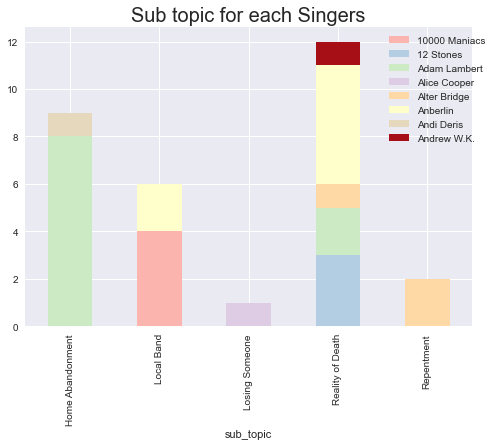

In [352]:
megadf.groupby(['sub_topic','Artist']).size().unstack().plot(kind='bar',stacked=True,color=['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#a50f15'])
plt.title('Sub topic for each Singers',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('Corex.png',dpi=100, bbox_inches='tight')

# Content-based Recommender System 

In [127]:
merged_data['Counts'] = merged_data.groupby(['Artist'])['topic'].transform('count')

In [128]:
merged_data.head()

,Artist,Songs,Popularity,ALink,Genre,Genres,SName,SLink,Lyric,Idiom,length,song_topic,topic,parsed,songs_subtopic,Counts
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of ...,ENGLISH,154,0,Reality,"(i, could, feel, at, the, time, there, was, no...",False,264
1,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close...,ENGLISH,246,5,Desire,"(take, me, now, baby, here, as, i, am, hold, m...",False,264
2,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember nev...,ENGLISH,181,5,Desire,"(these, are, these, are, days, you, ll, rememb...",False,264
3,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,A Campfire Song,/10000-maniacs/a-campfire-song.html,a lie to say o my mountain has coal veins an...,ENGLISH,272,0,Reality,"(a, lie, to, say, o, my, mountain, has, coal, ...",False,264
4,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,trudging slowly over wet sand back to the ben...,ENGLISH,117,2,Coming of age/Growing up,"(trudging, slowly, over, wet, sand, back, to, ...",False,264


### Look for the singers who sang more than 70 topics

In [129]:
singercount = merged_data[["topic","Artist"]].groupby("Artist").count()
singercount = singercount[singercount["topic"] >= 70]
singercount=singercount.head(10)
print(singercount)

                   topic
Artist                  
10000 Maniacs        264
12 Stones            100
3 Doors Down         116
311                  217
A Day To Remember    105
AC/DC                214
Adam Lambert         268
Aerosmith            266
Alanis Morissette    202
Alesana               99


### Look for the topics which have more than 70 singers

In [130]:
topiccount = merged_data[["topic","Artist"]].groupby("topic").count()
topiccount = topiccount[topiccount["Artist"] >= 70]
topiccount=topiccount.head(10)
print(topiccount)

                          Artist
topic                           
Coming of age/Growing up    7614
Desire                      1518
Friendship                  1752
Heartbreak                  1421
Home                        2433
Reality                     6121


### Keep only the popular topics and active singers

In [131]:
recomm_df = merged_data[merged_data["Artist"].isin(singercount.index) & merged_data["topic"].isin(topiccount.index)]

In [132]:
recomm_df.head()

,Artist,Songs,Popularity,ALink,Genre,Genres,SName,SLink,Lyric,Idiom,length,song_topic,topic,parsed,songs_subtopic,Counts
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,More Than This,/10000-maniacs/more-than-this.html,i could feel at the time there was no way of ...,ENGLISH,154,0,Reality,"(i, could, feel, at, the, time, there, was, no...",False,264
1,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Because The Night,/10000-maniacs/because-the-night.html,take me now baby here as i am hold me close...,ENGLISH,246,5,Desire,"(take, me, now, baby, here, as, i, am, hold, m...",False,264
2,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,These Are Days,/10000-maniacs/these-are-days.html,these are these are days you ll remember nev...,ENGLISH,181,5,Desire,"(these, are, these, are, days, you, ll, rememb...",False,264
3,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,A Campfire Song,/10000-maniacs/a-campfire-song.html,a lie to say o my mountain has coal veins an...,ENGLISH,272,0,Reality,"(a, lie, to, say, o, my, mountain, has, coal, ...",False,264
4,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,trudging slowly over wet sand back to the ben...,ENGLISH,117,2,Coming of age/Growing up,"(trudging, slowly, over, wet, sand, back, to, ...",False,264


In [133]:
recommender_matrix = recomm_df.pivot_table(index='Artist', columns="topic", values="Counts",aggfunc='first').fillna(0)

In [134]:
recommender_matrix

topic,Coming of age/Growing up,Desire,Friendship,Heartbreak,Home,Reality
Artist,,,,,,
10000 Maniacs,264.0,264.0,264.0,264.0,264.0,264.0
12 Stones,100.0,100.0,100.0,0.0,100.0,100.0
3 Doors Down,116.0,116.0,116.0,116.0,116.0,116.0
311,217.0,217.0,217.0,217.0,217.0,217.0
A Day To Remember,105.0,105.0,105.0,0.0,105.0,105.0
AC/DC,214.0,214.0,214.0,214.0,214.0,214.0
Adam Lambert,268.0,268.0,268.0,268.0,268.0,268.0
Aerosmith,266.0,266.0,266.0,266.0,266.0,266.0
Alanis Morissette,202.0,202.0,202.0,202.0,202.0,202.0


In [384]:
U,Sigma,VT=svd(recommender_matrix)

In [136]:
VT = VT[:6,:]
pd.DataFrame(VT)

,0,1,2,3,4,5
0,-4.113168e-01,-4.113168e-01,-4.113168e-01,-3.925463e-01,-0.411317,-0.411317
1,1.755521e-01,1.755521e-01,1.755521e-01,-9.197322e-01,0.175552,0.175552
2,8.831933e-01,-3.576250e-01,-1.751894e-01,1.469108e-17,-0.175189,-0.175189
3,1.413140e-01,8.198197e-01,-3.203779e-01,-3.020515e-16,-0.320378,-0.320378
4,-1.417017e-15,-3.209519e-16,8.164966e-01,2.488329e-16,-0.408248,-0.408248
5,0.000000e+00,-1.249727e-17,-5.921788e-17,1.031269e-17,-0.707107,0.707107


In [137]:
pd.DataFrame(VT.T)

,0,1,2,3,4,5
0,-0.411317,0.175552,8.831933e-01,1.413140e-01,-1.417017e-15,0.000000e+00
1,-0.411317,0.175552,-3.576250e-01,8.198197e-01,-3.209519e-16,-1.249727e-17
2,-0.411317,0.175552,-1.751894e-01,-3.203779e-01,8.164966e-01,-5.921788e-17
3,-0.392546,-0.919732,1.469108e-17,-3.020515e-16,2.488329e-16,1.031269e-17
4,-0.411317,0.175552,-1.751894e-01,-3.203779e-01,-4.082483e-01,-7.071068e-01
5,-0.411317,0.175552,-1.751894e-01,-3.203779e-01,-4.082483e-01,7.071068e-01


In [138]:
U = U[:,:6]
pd.DataFrame(U)

,0,1,2,3,4,5
0,-0.426002,-0.085363,0.284180,-0.208491,-0.146685,0.458821
1,-0.135501,0.676213,0.139952,0.696810,-0.008592,0.061697
2,-0.187183,-0.037508,0.098321,-0.011960,0.973893,0.048652
3,-0.350161,-0.070166,0.103063,0.014711,-0.040628,-0.862740
4,-0.142276,0.710023,-0.133287,-0.663629,0.008183,-0.058759
5,-0.345320,-0.069196,0.088684,0.000391,-0.042423,0.036225
6,-0.432456,-0.086657,0.393974,0.021939,-0.155376,0.063716
7,-0.429229,-0.086010,-0.784969,0.172344,-0.018634,0.148339
8,-0.325956,-0.065316,0.018776,0.006101,-0.042209,0.023692
9,-0.159751,-0.032011,-0.286341,0.001998,-0.012409,-0.087170


In [385]:
Sigma = Sigma[:6]
pd.DataFrame(np.diag(sigma))

,0,1,2,3,4,5
0,1517.764005,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000,129.805334,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000,0.000000,2.014333e-14,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.000000,0.000000e+00,3.621483e-15,0.000000e+00,0.000000e+00
4,0.000000,0.000000,0.000000e+00,0.000000e+00,1.560096e-45,0.000000e+00
5,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.564326e-61


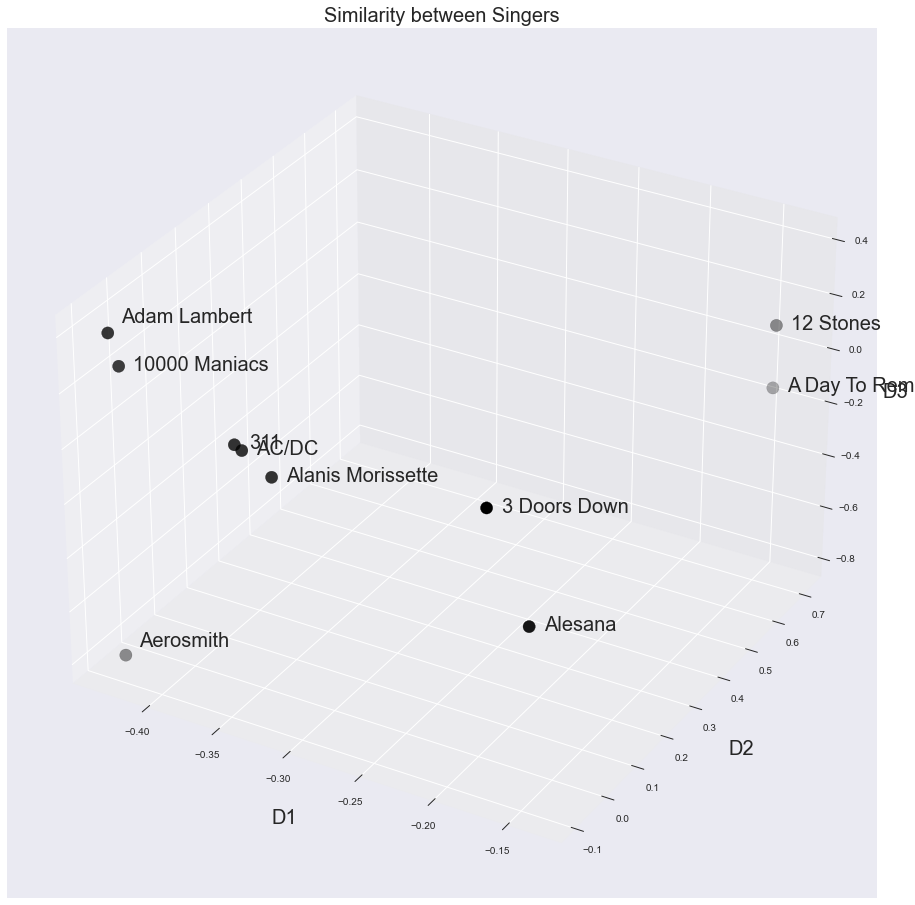

In [324]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn')

fig = plt.figure(figsize=(20,16))
ax = fig.gca(projection='3d')
ax.scatter(U[:,0],U[:,1],U[:,2],c='k',s=150);
ax.set_xlabel("D1", fontsize=20, labelpad=20)
ax.set_ylabel("D2", fontsize=20, labelpad=20)
ax.set_zlabel("D3", fontsize=20, labelpad=20);

lbls = recommender_matrix.index
offset = 0.01
for i, txt in enumerate(lbls):
    if i not in [6,7]:
        ax.text(U[i,0]+offset,U[i,1],U[i,2],txt, fontsize=20)
    else:
        ax.text(U[i,0]+offset,U[i,1],U[i,2]+5*offset,txt, fontsize=20)
plt.title('Similarity between Singers',fontsize=20)
plt.savefig('reco_sys.png')

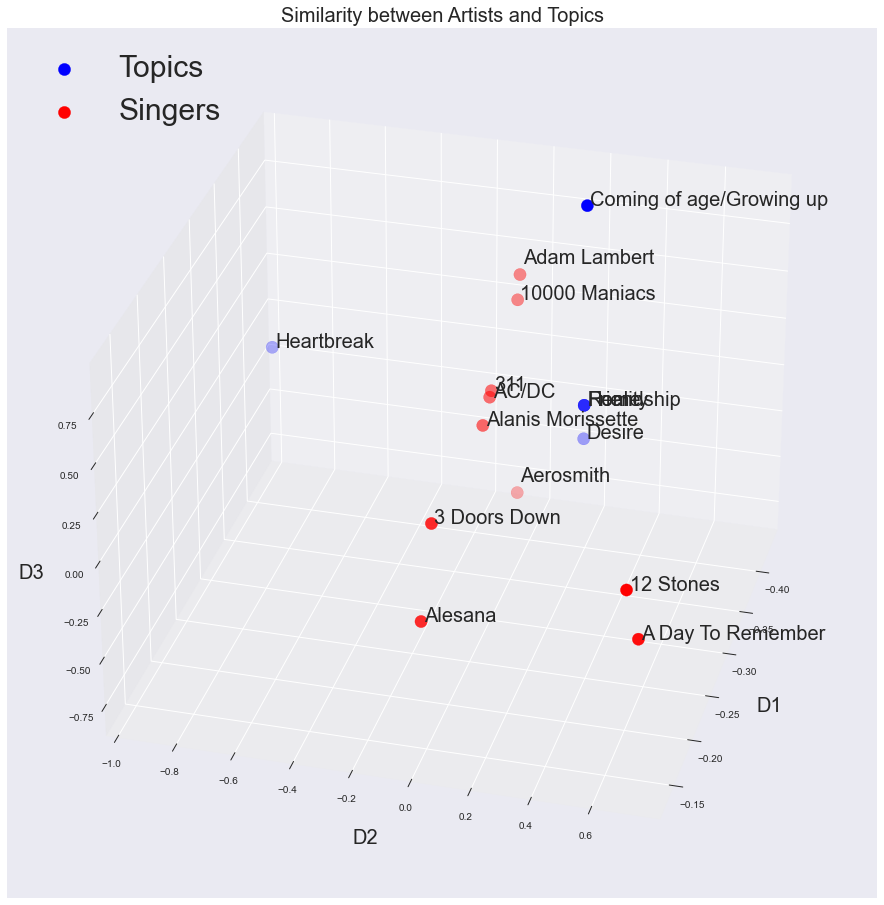

In [325]:
fig = plt.figure(figsize=(20,16))
ax = fig.gca(projection='3d')
ax.scatter(VT.T[:,0],VT.T[:,1],VT.T[:,2],c='b',s=150, label="Topics");
ax.scatter(U[:,0],U[:,1],U[:,2],c='r',s=150, label="Singers");
ax.set_xlabel("D1", fontsize=20, labelpad=20)
ax.set_ylabel("D2", fontsize=20, labelpad=20)
ax.set_zlabel("D3", fontsize=20, labelpad=20);

lbls = recommender_matrix.columns
item_offset = 0.01
for i, txt in enumerate(lbls):
    if i not in [6,7]:
        ax.text(VT.T[i,0],VT.T[i,1]+item_offset,VT.T[i,2],txt, fontsize=20)
    else:
        ax.text(VT.T[i,0],VT.T[i,1]+item_offset,VT.T[i,2]+5*item_offset,txt, fontsize=20)

lbls = recommender_matrix.index
offset = 0.01
for i, txt in enumerate(lbls):
    if i not in [6,7]:
        ax.text(U[i,0],U[i,1]+offset,U[i,2],txt, fontsize=20)
    else:
        ax.text(U[i,0],U[i,1]+offset,U[i,2]+6*offset,txt, fontsize=20)
ax.view_init(30,15)
plt.legend(loc="upper left", fontsize=30);
plt.title('Similarity between Artists and Topics',fontsize=20)
plt.savefig('reco_sys2.png')

In [245]:
num_topics=6
compare_topic = 2
for topic in range(num_topics):
    if topic != compare_topic:
        print("Topic %s & %s: "%(compare_topic,topic), np.dot(VT.T[compare_topic],VT.T[topic]))
# 0: Coming of age/Growing up , 1: Desire , 2: Friendship , 3: Heartbreak , 4: Home , 5: Reality

Topic 2 & 0:  2.7755575615628914e-17
Topic 2 & 1:  2.7755575615628914e-17
Topic 2 & 3:  1.4970804065976809e-16
Topic 2 & 4:  -2.7755575615628914e-17
Topic 2 & 5:  -1.1102230246251565e-16


In [246]:
num_singers=10
compare_singer = 0
for singer in range(num_singers):
    if singer != compare_singer:
        print("Singer %s & %s: "%(compare_singer,singer), np.dot(U[compare_singer],U[singer]))

Singer 0 & 1:  -1.5265566588595902e-16
Singer 0 & 2:  -5.551115123125783e-17
Singer 0 & 3:  1.6653345369377348e-16
Singer 0 & 4:  -1.1796119636642288e-16
Singer 0 & 5:  1.942890293094024e-16
Singer 0 & 6:  1.1102230246251565e-16
Singer 0 & 7:  -2.7755575615628914e-16
Singer 0 & 8:  -4.163336342344337e-17
Singer 0 & 9:  -4.163336342344337e-17


In [247]:
def get_recommends(topics, VT, num_recom=2):
    recs = []
    for topic in range(VT.T.shape[0]):
        if topic != topics:
            recs.append([topic,np.dot(VT.T[topics],VT.T[topic])])
    final_rec = [i[0] for i in sorted(recs,key=lambda x: x[1],reverse=True)]
    return final_rec[:num_recom]

print(get_recommends(0,VT,num_recom=2))
# 0: Coming of age/Growing up -> 2: Friendship & 4: Home

[2, 4]


In [248]:
def get_recommends_user(singers, U, df):
    singersrecs = []
    for singer in range(U.shape[0]):
        if singer!= singers:
            singersrecs.append([singer,np.dot(U[singers],U[singer])])
    final_rec = [i[0] for i in sorted(singersrecs,key=lambda x: x[1],reverse=True)]
    comp_singer = final_rec[0]
    print("Singer #%s's most similar singer is Singer #%s "% (singers, comp_singer))
    rec_likes = df.iloc[comp_singer]
    current = df.iloc[singers]
    recs = []
    for i,item in enumerate(current):
        if item != rec_likes[i] and rec_likes[i]!=0:
            recs.append(i)
    return recs[:-1]

singer_to_rec = 8
print("Topics for Singer %s to check out: "% singer_to_rec, get_recommends_user(singer_to_rec,U,recommender_matrix))

Singer #8's most similar singer is Singer #3 
Topics for Singer 8 to check out:  [0, 1, 2, 3, 4]
